In [96]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Start eval runs

In [119]:
base_dir = Path(
    "/nas/ucb/ebronstein/minecraft-building-assistance-game/data/logs/MbagAlphaZero/2_players/11x10x10/craftassist/teleportation_False/inf_blocks_True/human_bc_6x64_lr_0.001_20240703_20"
)

checkpoints = [
    ### max_seq_len ablation
    # 12x128 with increasing max_seq_len
    # "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_8/gamma_0.95/lr_0.001/weight_decay_0/model_12x128/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/position_embedding_angle_10000/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/459417/2024-09-09_22-43-20/1/checkpoint_000025",
    # "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_16/gamma_0.95/lr_0.001/weight_decay_0/model_12x128/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/position_embedding_angle_10000/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/459418/2024-09-09_22-43-20/1/checkpoint_000025",
    # "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_32/gamma_0.95/lr_0.001/weight_decay_0/model_12x128/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/position_embedding_angle_10000/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/459419/2024-09-09_22-43-20/1/checkpoint_000025",
    # "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_64/gamma_0.95/lr_0.001/weight_decay_0/model_12x128/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/position_embedding_angle_10000/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/459420/2024-09-09_22-43-20/1/checkpoint_000025",
    # "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.0003/model_12x128/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/position_embedding_angle_10000/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/458488/2024-09-06_19-16-35/1/checkpoint_000025",

    ### Best according to unplaced_blocks_goal_cross_entropy
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.0001/model_16x256/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/456231/2024-09-06_06-17-59/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_8/gamma_0.95/lr_0.001/weight_decay_0/model_12x128/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/position_embedding_angle_10000/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/459417/2024-09-09_22-43-20/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.0003/model_12x256/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/456229/2024-09-06_06-18-28/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_64/gamma_0.95/lr_0.001/weight_decay_0/model_12x128/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/position_embedding_angle_10000/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/459420/2024-09-09_22-43-20/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.001/weight_decay_0/model_9x64/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/position_embedding_angle_10000/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/459194/2024-09-07_21-21-48/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_16/gamma_0.95/lr_0.001/weight_decay_0/model_12x128/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/position_embedding_angle_10000/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/459418/2024-09-09_22-43-20/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_32/gamma_0.95/lr_0.001/weight_decay_0/model_12x128/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/position_embedding_angle_10000/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/459419/2024-09-09_22-43-20/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.0003/weight_decay_0.0001/model_12x256/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/position_embedding_angle_10000/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/459188/2024-09-07_20-47-58/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_8/gamma_0.95/lr_0.001/weight_decay_0/model_8x64/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/position_embedding_angle_10000/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/459271/2024-09-08_13-29-56/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.001/model_8x64/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/position_embedding_angle_10/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/458496/2024-09-06_12-13-57/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.0003/weight_decay_0/model_12x192/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/position_embedding_angle_10000/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/458597/2024-09-06_23-20-58/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.001/model_8x64/sep_transformer/dim_feedforward_256/num_heads_4/norm_first_False/position_embedding_size_18/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/455692/2024-09-05_19-10-41/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.001/model_12x128/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/455687/2024-09-06_02-08-45/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_32/gamma_0.95/lr_0.001/model_8x64/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/455689/2024-09-05_19-06-42/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_32/gamma_0.95/lr_0.001/weight_decay_0/model_8x64/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/position_embedding_angle_10000/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/459273/2024-09-08_13-29-56/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.0005/model_8x128/no_sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/456234/2024-09-05_23-17-59/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.001/model_8x128/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/456227/2024-09-05_23-17-58/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.001/model_8x256/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/456228/2024-09-05_23-17-58/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.001/model_8x64/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_144/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/455698/2024-09-06_02-19-08/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.001/model_8x64/sep_transformer/dim_feedforward_512/num_heads_4/norm_first_False/position_embedding_size_18/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/456236/2024-09-05_23-17-58/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.0003/weight_decay_0/model_8x128/no_sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/position_embedding_angle_10000/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/458600/2024-09-06_23-21-49/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.001/model_8x64/sep_transformer/dim_feedforward_64/num_heads_16/norm_first_False/position_embedding_size_18/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/456237/2024-09-06_06-17-59/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.0003/model_12x128/sep_transformer/dim_feedforward_512/num_heads_4/norm_first_False/position_embedding_size_144/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/456240/2024-09-06_06-44-01/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.0003/weight_decay_0/model_12x128/sep_transformer/dim_feedforward_256/num_heads_8/norm_first_False/position_embedding_size_144/position_embedding_angle_10/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/459276/2024-09-08_20-29-59/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.001/model_8x64/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_576/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/456239/2024-09-06_06-44-05/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.001/model_8x64/sep_transformer/dim_feedforward_128/num_heads_4/norm_first_False/position_embedding_size_18/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/455691/2024-09-05_19-10-11/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.0005/model_16x128/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/455688/2024-09-06_02-15-13/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_4/gamma_0.95/lr_0.001/weight_decay_0/model_8x64/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/position_embedding_angle_10000/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/459270/2024-09-08_13-29-56/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.001/model_8x64/sep_transformer/dim_feedforward_64/num_heads_8/norm_first_False/position_embedding_size_18/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/455693/2024-09-05_19-10-42/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.001/model_8x64/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/position_embedding_angle_10000/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/458486/2024-09-06_12-13-30/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.001/model_8x64/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/456226/2024-09-05_23-17-58/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.001/weight_decay_0/model_8x64/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/position_embedding_angle_10000/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/458594/2024-09-06_16-19-17/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.0003/weight_decay_0/model_8x256/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/position_embedding_angle_10000/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/458595/2024-09-06_16-19-17/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.0003/model_12x256/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/position_embedding_angle_10000/interleave_lstm/grad_clip_10/prev_goal_kl_10/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/458498/2024-09-06_19-56-14/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_256/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_256/gamma_0.95/lr_0.001/model_8x64/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/456235/2024-09-05_23-17-59/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.001/model_8x64/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_288/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/456238/2024-09-06_06-25-25/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_16/gamma_0.95/lr_0.001/weight_decay_0/model_8x64/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/position_embedding_angle_10000/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/459272/2024-09-08_13-29-56/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_64/gamma_0.95/lr_0.001/model_8x64/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/455690/2024-09-05_19-07-11/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_64/gamma_0.95/lr_0.001/weight_decay_0/model_8x64/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/position_embedding_angle_10000/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/459274/2024-09-08_13-29-56/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.0003/model_12x128/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/position_embedding_angle_10000/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/458488/2024-09-06_19-16-35/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.001/model_8x64/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_72/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/455697/2024-09-06_02-17-13/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.001/model_8x64/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_36/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/455696/2024-09-06_02-15-43/1/checkpoint_000025",
    "batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.001/model_8x64/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_144/position_embedding_angle_10/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/458497/2024-09-06_12-13-57/1/checkpoint_000025",
]

checkpoints = [base_dir / checkpoint for checkpoint in checkpoints]

In [120]:
qos = "scavenger"
partition = "scavenger" if qos == "scavenger" else None

for checkpoint in checkpoints:
    if not checkpoint.exists():
        raise FileNotFoundError(checkpoint)

    partition_str = "" if partition is None else f"--partition={partition}"
    print(
        f"CHECKPOINT={checkpoint} sbatch --qos={qos} {partition_str} --requeue scripts/slurm_eval_goal_pred.sh",
        end="\n\n",
    )

CHECKPOINT=/nas/ucb/ebronstein/minecraft-building-assistance-game/data/logs/MbagAlphaZero/2_players/11x10x10/craftassist/teleportation_False/inf_blocks_True/human_bc_6x64_lr_0.001_20240703_20/batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_128/gamma_0.95/lr_0.0001/model_16x256/sep_transformer/dim_feedforward_64/num_heads_4/norm_first_False/position_embedding_size_18/interleave_lstm/grad_clip_10/prev_goal_kl_3/goal_loss_coeff_3/vf_loss_coeff_0.01/other_agent_action_predictor_loss_coeff_1.0/pretrain_True/456231/2024-09-06_06-17-59/1/checkpoint_000025 sbatch --qos=scavenger --partition=scavenger --requeue scripts/slurm_eval_goal_pred.sh

CHECKPOINT=/nas/ucb/ebronstein/minecraft-building-assistance-game/data/logs/MbagAlphaZero/2_players/11x10x10/craftassist/teleportation_False/inf_blocks_True/human_bc_6x64_lr_0.001_20240703_20/batch_32768/horizon_1500/truncate_episodes/rollout_128/sgd_minibatch_512/replay_4/train_2x4/max_seq_len_8/gam

# Plots

In [88]:
def get_params_from_checkpoint_path(checkpoint_path):
    param_prefixes = [
        "batch",
        "horizon",
        "rollout",
        "sgd_minibatch",
        "replay",
        "train",
        "max_seq_len",
        "gamma",
        "lr",
        "model",
        "dim_feedforward",
        "num_heads",
        "norm_first",
        "position_embedding_size",
        "position_embedding_angle",
        "grad_clip",
        "prev_goal_kl",
        "goal_loss_coeff",
        "vf_loss_coeff",
        "other_agent_action_predictor_loss_coeff",
    ]
    params = {}

    for part in checkpoint_path.parts:
        for prefix in param_prefixes:
            if part.startswith(prefix):
                params[prefix] = part.split(prefix + "_")[1]
                break

        if part == "interleave_lstm":
            params["interleave_lstm"] = True
        elif "sep_transformer" in part:
            # True for "sep_transformer" and False for "no_sep_transformer"
            params["sep_transformer"] = part.startswith("sep_transformer")

    return params


def episode_results_to_df(episode_results):
    common_keys = ("cross_entropy", "cross_entropy_different")
    per_agent_keys = (
        "cross_entropy_by_last_interacted",
        "cross_entropy_different_by_last_interacted",
    )
    rows = []
    for i, episode in enumerate(episode_results):
        common_row_dict = {key: episode[key] for key in common_keys}
        common_row_dict["episode"] = i
        agent_ids = []
        for key in per_agent_keys:
            agent_ids.extend(list(episode[key].keys()))
        agent_ids = set(agent_ids)
        for agent_id in agent_ids:
            row_dict = common_row_dict.copy()
            row_dict["agent_id"] = agent_id
            for key in per_agent_keys:
                row_dict[key] = episode[key][agent_id]
            rows.append(row_dict)

    return pd.DataFrame(rows)


def load_goal_pred_dfs_for_checkpoint(checkpoint_path):
    checkpoint_path = Path(checkpoint_path)
    episode_results_paths = list(
        checkpoint_path.glob("evaluate_on_*/*/episode_results.pickle")
    )

    max_run_id_per_eval = {}
    for path in episode_results_paths:
        parts = path.parts
        eval_id = parts[-3]
        run_id = int(parts[-2])
        if eval_id not in max_run_id_per_eval:
            max_run_id_per_eval[eval_id] = run_id
        else:
            max_run_id_per_eval[eval_id] = max(max_run_id_per_eval[eval_id], run_id)

    dfs = []
    for eval_id, run_id in max_run_id_per_eval.items():
        episode_result_path = (
            checkpoint_path / eval_id / str(run_id) / "episode_results.pickle"
        )

        with open(episode_result_path, "rb") as f:
            episode_results = pickle.load(f)
        df = episode_results_to_df(episode_results)
        df["checkpoint"] = str(checkpoint_path)
        df["split"] = episode_result_path.parts[-3][len("evaluate_on_") :].split("_")[0]

        params = get_params_from_checkpoint_path(checkpoint_path)
        for key, value in params.items():
            df[key] = value

        dfs.append(df)

    return dfs

In [89]:
all_df = []
for checkpoint_path in checkpoints:
    dfs = load_goal_pred_dfs_for_checkpoint(checkpoint_path)
    all_df.extend(dfs)

all_df = pd.concat(all_df, ignore_index=True)

In [106]:
all_df

,cross_entropy,cross_entropy_different,episode,agent_id,cross_entropy_by_last_interacted,cross_entropy_different_by_last_interacted,checkpoint,split,batch,horizon,...,num_heads,norm_first,position_embedding_size,position_embedding_angle,interleave_lstm,grad_clip,prev_goal_kl,goal_loss_coeff,vf_loss_coeff,other_agent_action_predictor_loss_coeff
0,0.596311,1.996324,0,0,0.597406,4.550035,/nas/ucb/ebronstein/minecraft-building-assista...,train,32768,1500,...,4,False,18,10000,True,10,3,3,0.01,1.0
1,0.596311,1.996324,0,1,0.582214,0.558573,/nas/ucb/ebronstein/minecraft-building-assista...,train,32768,1500,...,4,False,18,10000,True,10,3,3,0.01,1.0
2,0.690744,4.553803,1,0,0.689809,5.293004,/nas/ucb/ebronstein/minecraft-building-assista...,train,32768,1500,...,4,False,18,10000,True,10,3,3,0.01,1.0
3,0.690744,4.553803,1,1,0.734471,0.780565,/nas/ucb/ebronstein/minecraft-building-assista...,train,32768,1500,...,4,False,18,10000,True,10,3,3,0.01,1.0
4,1.058082,3.449182,2,0,1.130716,4.697588,/nas/ucb/ebronstein/minecraft-building-assista...,train,32768,1500,...,4,False,18,10000,True,10,3,3,0.01,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.451259,1.711660,47,1,0.043886,0.043508,/nas/ucb/ebronstein/minecraft-building-assista...,train,32768,1500,...,4,False,18,10000,True,10,3,3,0.01,1.0
996,0.211954,1.045513,48,0,0.222495,2.102274,/nas/ucb/ebronstein/minecraft-building-assista...,train,32768,1500,...,4,False,18,10000,True,10,3,3,0.01,1.0
997,0.211954,1.045513,48,1,0.107730,0.102962,/nas/ucb/ebronstein/minecraft-building-assista...,train,32768,1500,...,4,False,18,10000,True,10,3,3,0.01,1.0
998,0.615842,2.811917,49,0,0.643484,4.157607,/nas/ucb/ebronstein/minecraft-building-assista...,train,32768,1500,...,4,False,18,10000,True,10,3,3,0.01,1.0


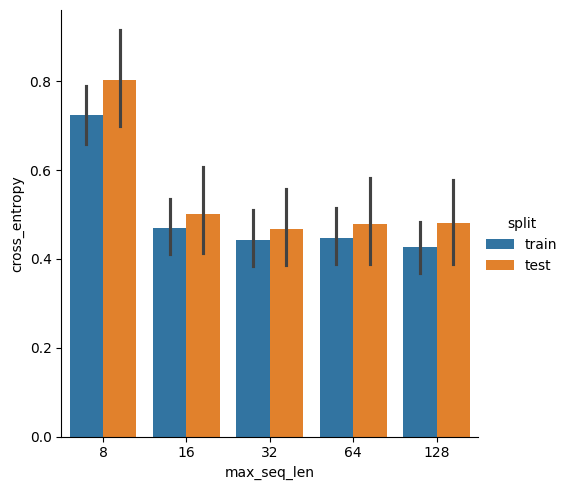

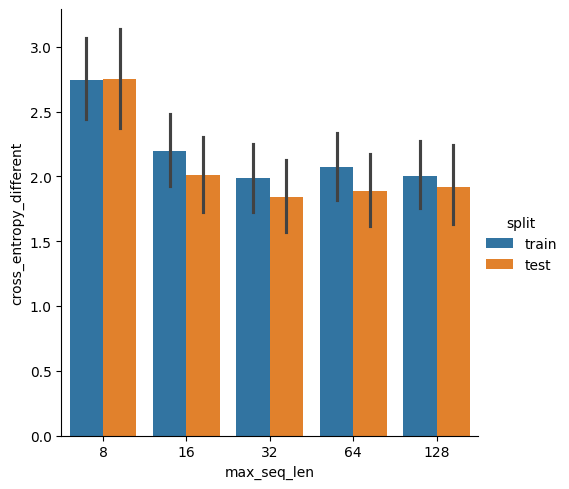

In [108]:
for y in ["cross_entropy", "cross_entropy_different"]:
    sns.catplot(
        data=all_df[all_df["agent_id"] == 0],
        kind="bar",
        x="max_seq_len",
        y=y,
        hue="split",
    )